## Worksheet 08
***

In [1]:
from sklearn.datasets import load_digits 
from sklearn.model_selection import train_test_split

import numpy as np
from numpy.linalg import lstsq
from scipy.sparse.linalg import lsqr
from scipy.sparse import dok_matrix, coo_matrix, vstack, eye
from scipy.ndimage.filters import gaussian_filter
from sklearn.utils import shuffle

%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
def fade_zeros(s):
    return ['color: lightgray' if v else 'color: black' for v in (0 == s)]
from IPython.display import display

%load_ext autoreload
%autoreload 2

### Denoising a CT image

In [2]:
def construct_X(M, alphas, Np=None, lmbda=0):
    """
    Construct design matrix X
    : param M: int 
        Tomogram is an array-like of shape (M, M)
    
    : param alphas: Array-like of shape (n_alphas, )
        List of measurement angles in degrees
        
    : param Np: Default=None
        Optional sensor resolution
    """
    # Define sensor size
    if Np is None:
        Np = int(np.ceil(np.sqrt(2) * M))
        if Np % 2 == 0:
            Np += 1
    # Number of angles
    No = len(alphas)
    # Define design matrix X
    D_beta = M * M
    D_y = No * Np
    
    # Flattened output coordinates
    j = np.mgrid[0 : D_beta].astype(np.int32)
    # Coordinate matrix for the output pixels
    C = (M - 1) / 2  # Center matrix
    grid = np.mgrid[-C : M - C, -C : M - C].swapaxes(1, 2).reshape(2, D_beta)
    
    # Collect indices and corresponding values for all iterations
    i_idx = []
    j_idx = []
    weights = []

    for k, alpha in enumerate(alphas):
        # Covert angle and projection vector    
        alph_rad = np.radians(alpha)
        proj_vec = np.array([np.cos(alph_rad), -np.sin(alph_rad)])
        # Project coordinates and adjust coordinates to sensor
        proj = np.dot(proj_vec, grid) + Np // 2
        # Compute sensor indices and weights below the projected points
        i = np.floor(proj)
        w = (i + 1) - proj
        # Rays falling outside the sensor are not counted
        clip = np.logical_and(0 <= i, i < Np-1)
        
        i_idx.append((i + k * Np)[clip])
        j_idx.append(j[clip])
        weights.append(w[clip])
        # Compute sensor indices and weights above the projected points
        w = proj - i
        i_idx.append((i + 1 + k * Np)[clip])
        j_idx.append(j[clip])
        weights.append(w[clip])
        
    # Construct matrix X
    i = np.concatenate(i_idx).astype(np.int32)
    j = np.concatenate(j_idx).astype(np.int32)
    w = np.concatenate(weights)
    X = coo_matrix((w, (i, j)), shape=(D_y, D_beta), dtype=np.float32)
    
    if lmbda > 0:
        reg = np.sqrt(lmbda) * eye(D_beta)
        X = vstack([X, reg])
        
    return X

In [3]:
# Reconstruct tomogram from 64 angles and variations of lambda
M = 195
Np = 275
y = np.load('hs_tomography/y_195.npy')
alphas = np.load('hs_tomography/alphas_195.npy')

# Reconstruct for 64 angles
idx = [int(np.ceil(len(alphas) * p/64)) for p in range(64)]
alphas_sub = alphas[idx]
y_sub = []
for j in idx:
    y_sub.extend(y[j * Np : (j + 1) * Np])
y_sub = np.asarray(y_sub)

# Extend y vector with zeros
y_sub_lmbda = np.hstack((y_sub, np.zeros(M ** 2)))

lmbda = list(10 ** i for i in range(0, 5))
lmbda.insert(0, 0)
lmbda

[0, 1, 10, 100, 1000, 10000]

λ =     0, shape of X = (17600, 38025), mean GV = 119.92763
λ =     1, shape of X = (55625, 38025), mean GV = 119.91784
λ =    10, shape of X = (55625, 38025), mean GV = 119.82968
λ =   100, shape of X = (55625, 38025), mean GV = 118.95303
λ =  1000, shape of X = (55625, 38025), mean GV = 110.79511
λ = 10000, shape of X = (55625, 38025), mean GV =  65.61257


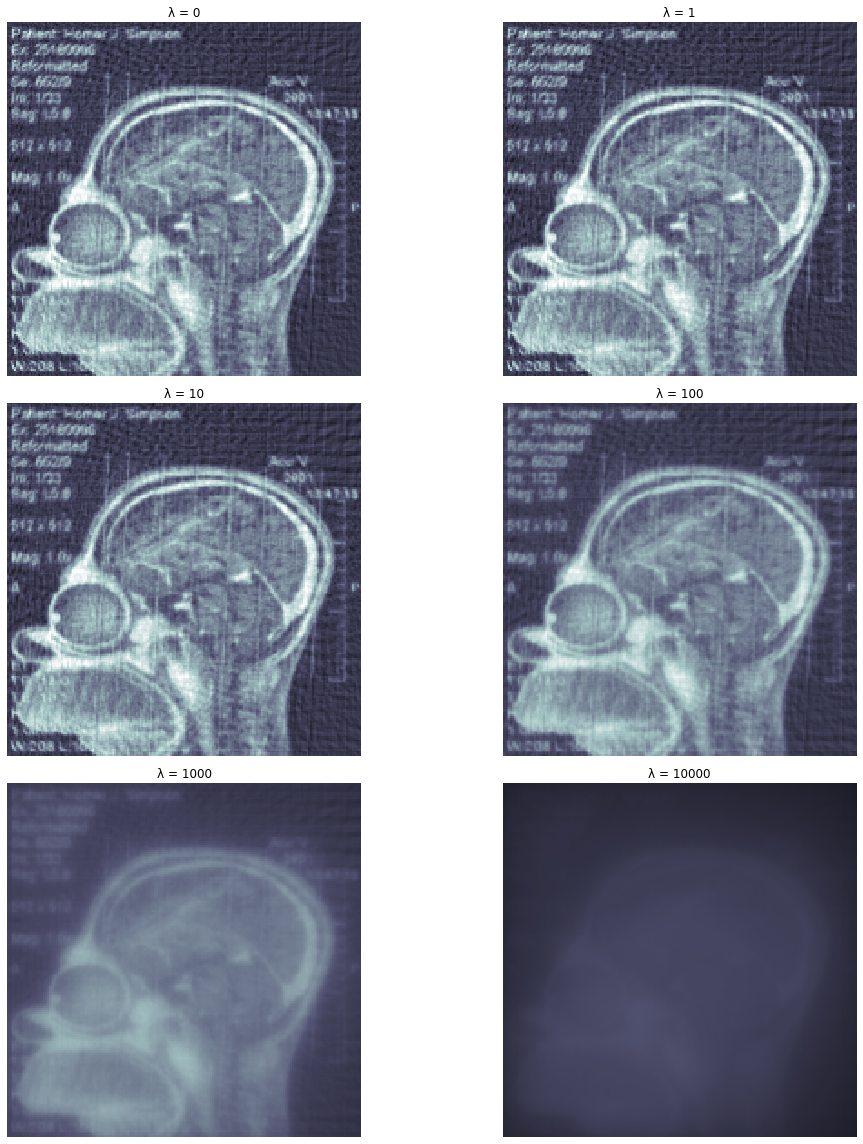

In [5]:
fig, ax = plt.subplots(3, 2, figsize=(16, 16))
for i in range(len(lmbda)):
    X = construct_X(M, alphas_sub, Np, lmbda=lmbda[i]).tocsc()
    theta = lsqr(X, y_sub if lmbda[i] == 0 else y_sub_lmbda, atol=1e-5, btol=1e-5)[0].reshape(195, 195)
    ax.flat[i].imshow(theta, vmin=0, vmax=255, interpolation='nearest', cmap='bone')
    ax.flat[i].set_title('λ = {}'.format(lmbda[i]))
    ax.flat[i].axis('off')
    print('λ = {}, shape of X = {}, mean GV = {}'.format(str(lmbda[i]).rjust(5), X.shape, str(round(np.mean(theta), 5)).rjust(9)))

fig.tight_layout()
plt.show()

In [ ]:
# Comparison with Gaussian filter of different std. deviations
